In [1]:

import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import time

In [8]:
BATCH_SIZE = 256
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Apple Devices have to be setup via MPS or Metal
NUM_WORKERS = 10
LEARNING_RATE = 0.01


# 1. Download Data & Test DataLoader 

This is later done in the DataModule directly, this is just for Testing 

In [3]:
train_dataset = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_dataloder = DataLoader(dataset=train_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             num_workers=NUM_WORKERS,
                             drop_last=True)

test_dataloder = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS, 
                            drop_last=True)

class_names = train_dataset.classes

train_dataloder, test_dataloder, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8e60a0e1f0>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [6]:
len(train_dataset), len(test_dataset), len(class_names)

(50000, 10000, 10)

## 1.2 Manual Inspect Data

torch.Size([32, 3, 32, 32]) torch.Size([32])


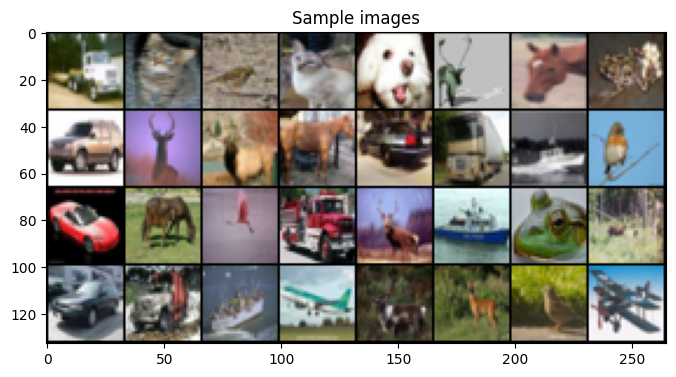

In [7]:
for image, label in train_dataloder:
    print(image.size(), label.size())
    break

plt.figure(figsize=(8, 8))
plt.title('Sample images')
plt.imshow(np.transpose(torchvision.utils.make_grid(image[:32], padding=1, normalize=True), (1, 2, 0)))
plt.show()


# 2. Setting up DataLoaders

In [9]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)

        self.train_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.RandomCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )

        self.test_transform = transforms.Compose(
            [
                transforms.Resize((70, 70)),
                transforms.CenterCrop((64, 64)),
                transforms.ToTensor(),
            ]
        )
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(root=self.data_path, train=True, transform=self.train_transform, download=False,
        )

        self.test = datasets.CIFAR10(root=self.data_path,train=False,transform=self.test_transform,download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS, 
            persistent_workers=True,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS, 
            persistent_workers=True,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
            persistent_workers=True,
        )
        return test_loader

In [10]:
import torch.nn as nn
import torch.nn.functional as F


# Regular PyTorch Module
class PyTorchModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

In [11]:
from torchinfo import summary

model = PyTorchModel(num_classes=10)
summary(model, (1, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=16,
        row_settings= ['var_names']
       )


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type (var_name))                  Input Shape      Output Shape     Param #          Trainable
PyTorchModel (PyTorchModel)              [1, 3, 64, 64]   [1, 10]          --               True
├─Sequential (features)                  [1, 3, 64, 64]   [1, 256, 1, 1]   --               True
│    └─Conv2d (0)                        [1, 3, 64, 64]   [1, 64, 15, 15]  23,296           True
│    └─ReLU (1)                          [1, 64, 15, 15]  [1, 64, 15, 15]  --               --
│    └─MaxPool2d (2)                     [1, 64, 15, 15]  [1, 64, 7, 7]    --               --
│    └─Conv2d (3)                        [1, 64, 7, 7]    [1, 192, 7, 7]   307,392          True
│    └─ReLU (4)                          [1, 192, 7, 7]   [1, 192, 7, 7]   --               --
│    └─MaxPool2d (5)                     [1, 192, 7, 7]   [1, 192, 3, 3]   --               --
│    └─Conv2d (6)                        [1, 192, 3, 3]   [1, 384, 3, 3]   663,936          True
│    └─ReLU (7)                  

In [145]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")



tensor([1.], device='mps:0')


In [12]:
import pytorch_lightning as pl
import torchmetrics


class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model
        if hasattr(model, "dropout_proba"):
            self.dropout_proba = model.dropout_proba


        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task= 'multiclass', num_classes=10)
        self.valid_acc = torchmetrics.Accuracy( task= 'multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy( task= 'multiclass', num_classes=10)

    def forward(self, x):
        return self.model(x)


    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()

        return loss 

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log(
            "valid_acc",
            self.valid_acc,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [13]:
torch.manual_seed(42)

data_module = DataModule(data_path="../data/")
pytorch_model = PyTorchModel(num_classes=10)

lightning_model = LightningModel(pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="valid_acc"
    )  
]
logger = CSVLogger(save_dir="logs/", name="model")

In [14]:
import time


trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=callbacks,
    accelerator="auto",
    devices="auto",  
    logger=logger,
    deterministic=False,
    log_every_n_steps=10,
)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time) / 60
print(f"Training took {runtime:.2f} min in total.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchModel       | 57.0 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)


Epoch 0:  46%|████▌     | 80/175 [05:45<06:50,  0.23it/s, v_num=12]        

InterruptedError: [Errno 4] Interrupted system call